### Installing dependencies

In [39]:
%pip install pandas seaborn matplotlib scikit-learn numpy openpyxl pipenv

Note: you may need to restart the kernel to use updated packages.


### Importing the necessary libraries for the workflow.

In [40]:
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.decomposition import PCA # type: ignore
from sklearn.experimental import enable_iterative_imputer  # type: ignore
from sklearn.impute import IterativeImputer  # type: ignore

### Loading data

In [41]:
print("Loading data...")
data = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", engine='openpyxl')
data_extracted_features = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", usecols=['Batch number', 'Genotype Neuron', 'Div calculated', 'Culture treatment', 'Capacitance', 'Input Resistance', 'Resting membrane potential ', 'Maximum firing ', 'Calculated input resistance', 'Rheobase', 'EPSC freq'])
print("\n")
print(data_extracted_features)

Loading data...


     Batch number Genotype Neuron  Div calculated   Culture treatment  \
0               1         TSC12.3              33                none   
1               1         TSC12.3              33                none   
2               1         TSC12.3              33                none   
3               1         TSC12.3              33                none   
4               1         TSC12.3              33                none   
..            ...             ...             ...                 ...   
683             3             WTC              58                none   
684             3             WTC              58  microglia 6 weekes   
685             3             WTC              58                none   
686             3             WTC              58                none   
687             3             WTC              58  microglia 6 weekes   

     Capacitance  Input Resistance  Resting membrane potential   \
0           54.0            2100.0    

### Preprocessing data

### Violin plot voor preprocessing

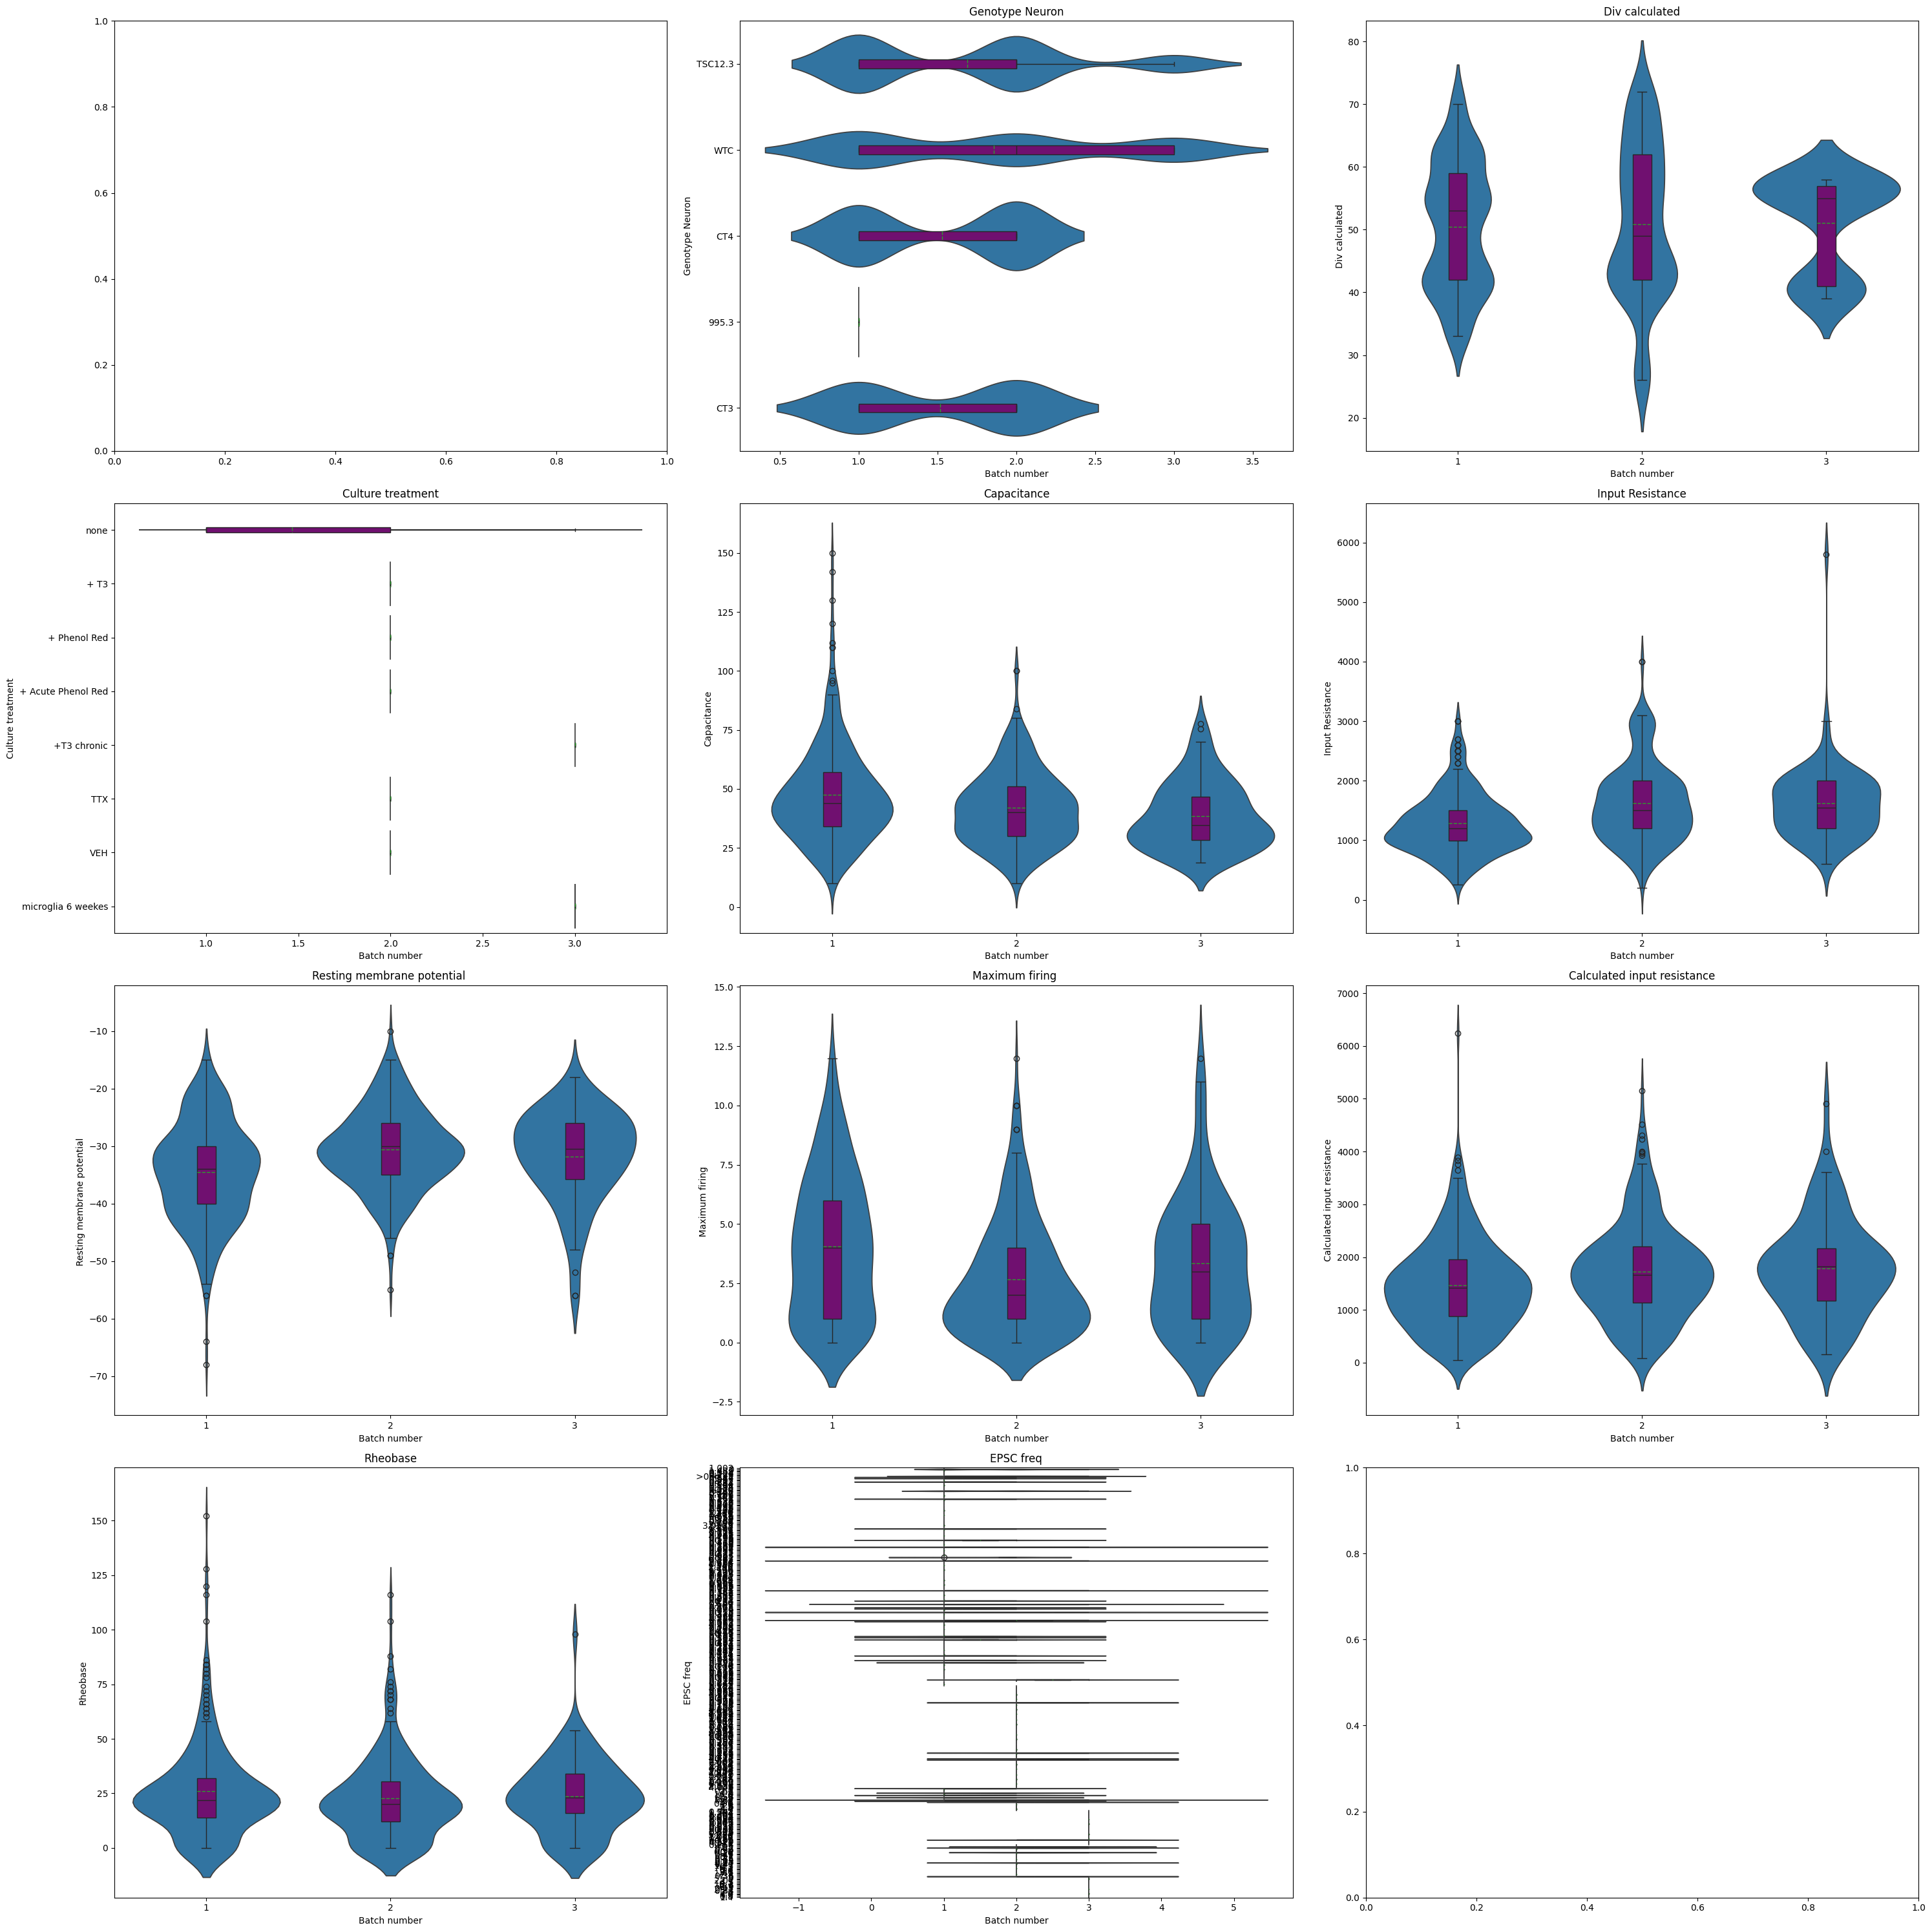

In [42]:
# sns.violinplot(x='Genotype Neuron', y='Capacitance', data=data_extracted_features, inner=None)
# sns.boxplot(x='Genotype Neuron', y='Capacitance', data=data_extracted_features, width=0.2, color="purple", showmeans=True, meanline=True)  
# plt.xlabel("Genotype Neuron")
# plt.ylabel("Capacitance")
# plt.title("Ephys violinplot")
# plt.show()

data_extracted_features_violin_pre = data_extracted_features.copy()
fig, axes = plt.subplots(4, 3, figsize=(30, 30))
axes = axes.flatten()
for i, feature in enumerate(data_extracted_features_violin_pre.columns):
    if feature == 'Batch number':
        continue
    sns.violinplot(x='Batch number', y=feature, data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
    sns.boxplot(x='Batch number', y=feature, data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
    axes[i].set_title(feature)
plt.tight_layout()
plt.show()

### MICE imputation

In [43]:
imputer = IterativeImputer(random_state=0)

mask = data_extracted_features['EPSC freq'].notna() & data_extracted_features['EPSC freq'].str.contains(">")
data_extracted_features.loc[mask, 'EPSC freq'] = np.nan
data_extracted_features['EPSC freq'] = pd.to_numeric(data_extracted_features['EPSC freq'])

object_columns = data_extracted_features.select_dtypes(include=['object']).columns
data_extracted_features_impute_copy = data_extracted_features.drop(columns=object_columns)
data_extracted_features_imputed = imputer.fit_transform(data_extracted_features_impute_copy)
data_extracted_features_imputed = pd.DataFrame(data_extracted_features_imputed, columns=data_extracted_features_impute_copy.columns)
for column in object_columns:
    data_extracted_features_imputed[column] = data_extracted_features[column]

#print(data_extracted_features_imputed)

# for column in data_imputed.columns:
#     data_extracted_features[column] = data_imputed[column]
# data_extracted_features_imputed = data_imputed.copy()
# print(data_extracted_features_imputed.columns)

#print(data_extracted_features_imputed)

# Iterate over each column in the DataFrame


for column in data_extracted_features.columns:
    missing_mask_column = data_extracted_features[column].isnull()  
    imputed_missing_mask_column = data_extracted_features_imputed[column].isnull()
    imputed_values_mask_column = (missing_mask_column) & (~imputed_missing_mask_column)
    imputed_values_column = data_extracted_features.loc[imputed_values_mask_column, column]
    imputed_value = data_extracted_features_imputed.loc[imputed_values_mask_column, column] 
    if not imputed_values_column.empty:
        imputed_value_pairs = [(original, imputed) for original, imputed in zip(imputed_values_column, imputed_value)]
        print(f"Imputed values for {column}:") 
        formatted_output = "\n".join([f"Index: {index + 2}\nOriginal Value: {original} --> Imputed value: {imputed}" for index, (original, imputed) in zip(imputed_values_column.index, imputed_value_pairs)])
        print(formatted_output + "\n")

    # if column not in object_columns:
    #     print(f"Imputed values for {column}:")
    #     print(imputed_values_column)
    #     print("\n".join(map(str, list(imputed_values_column))) + " --> " + "\n".join(map(str, list(imputed_value))) + "\n")
    #     print("\n")



Imputed values for Input Resistance:
Index: 651
Original Value: nan --> Imputed value: 1364.261752359775

Imputed values for Maximum firing :
Index: 632
Original Value: nan --> Imputed value: 2.2877776655061437
Index: 637
Original Value: nan --> Imputed value: 2.383535930035401

Imputed values for Calculated input resistance:
Index: 5
Original Value: nan --> Imputed value: 2463.573796853375
Index: 8
Original Value: nan --> Imputed value: 1689.2719019092024
Index: 11
Original Value: nan --> Imputed value: 1951.066673717263
Index: 21
Original Value: nan --> Imputed value: 1643.5939425633028
Index: 22
Original Value: nan --> Imputed value: 2180.369131643525
Index: 31
Original Value: nan --> Imputed value: 1935.4232154372742
Index: 65
Original Value: nan --> Imputed value: 1675.7906400101533
Index: 66
Original Value: nan --> Imputed value: 1264.5124415514279
Index: 67
Original Value: nan --> Imputed value: 1295.9082110403847
Index: 78
Original Value: nan --> Imputed value: 1009.27503896392

### Violin plot na preprocessing

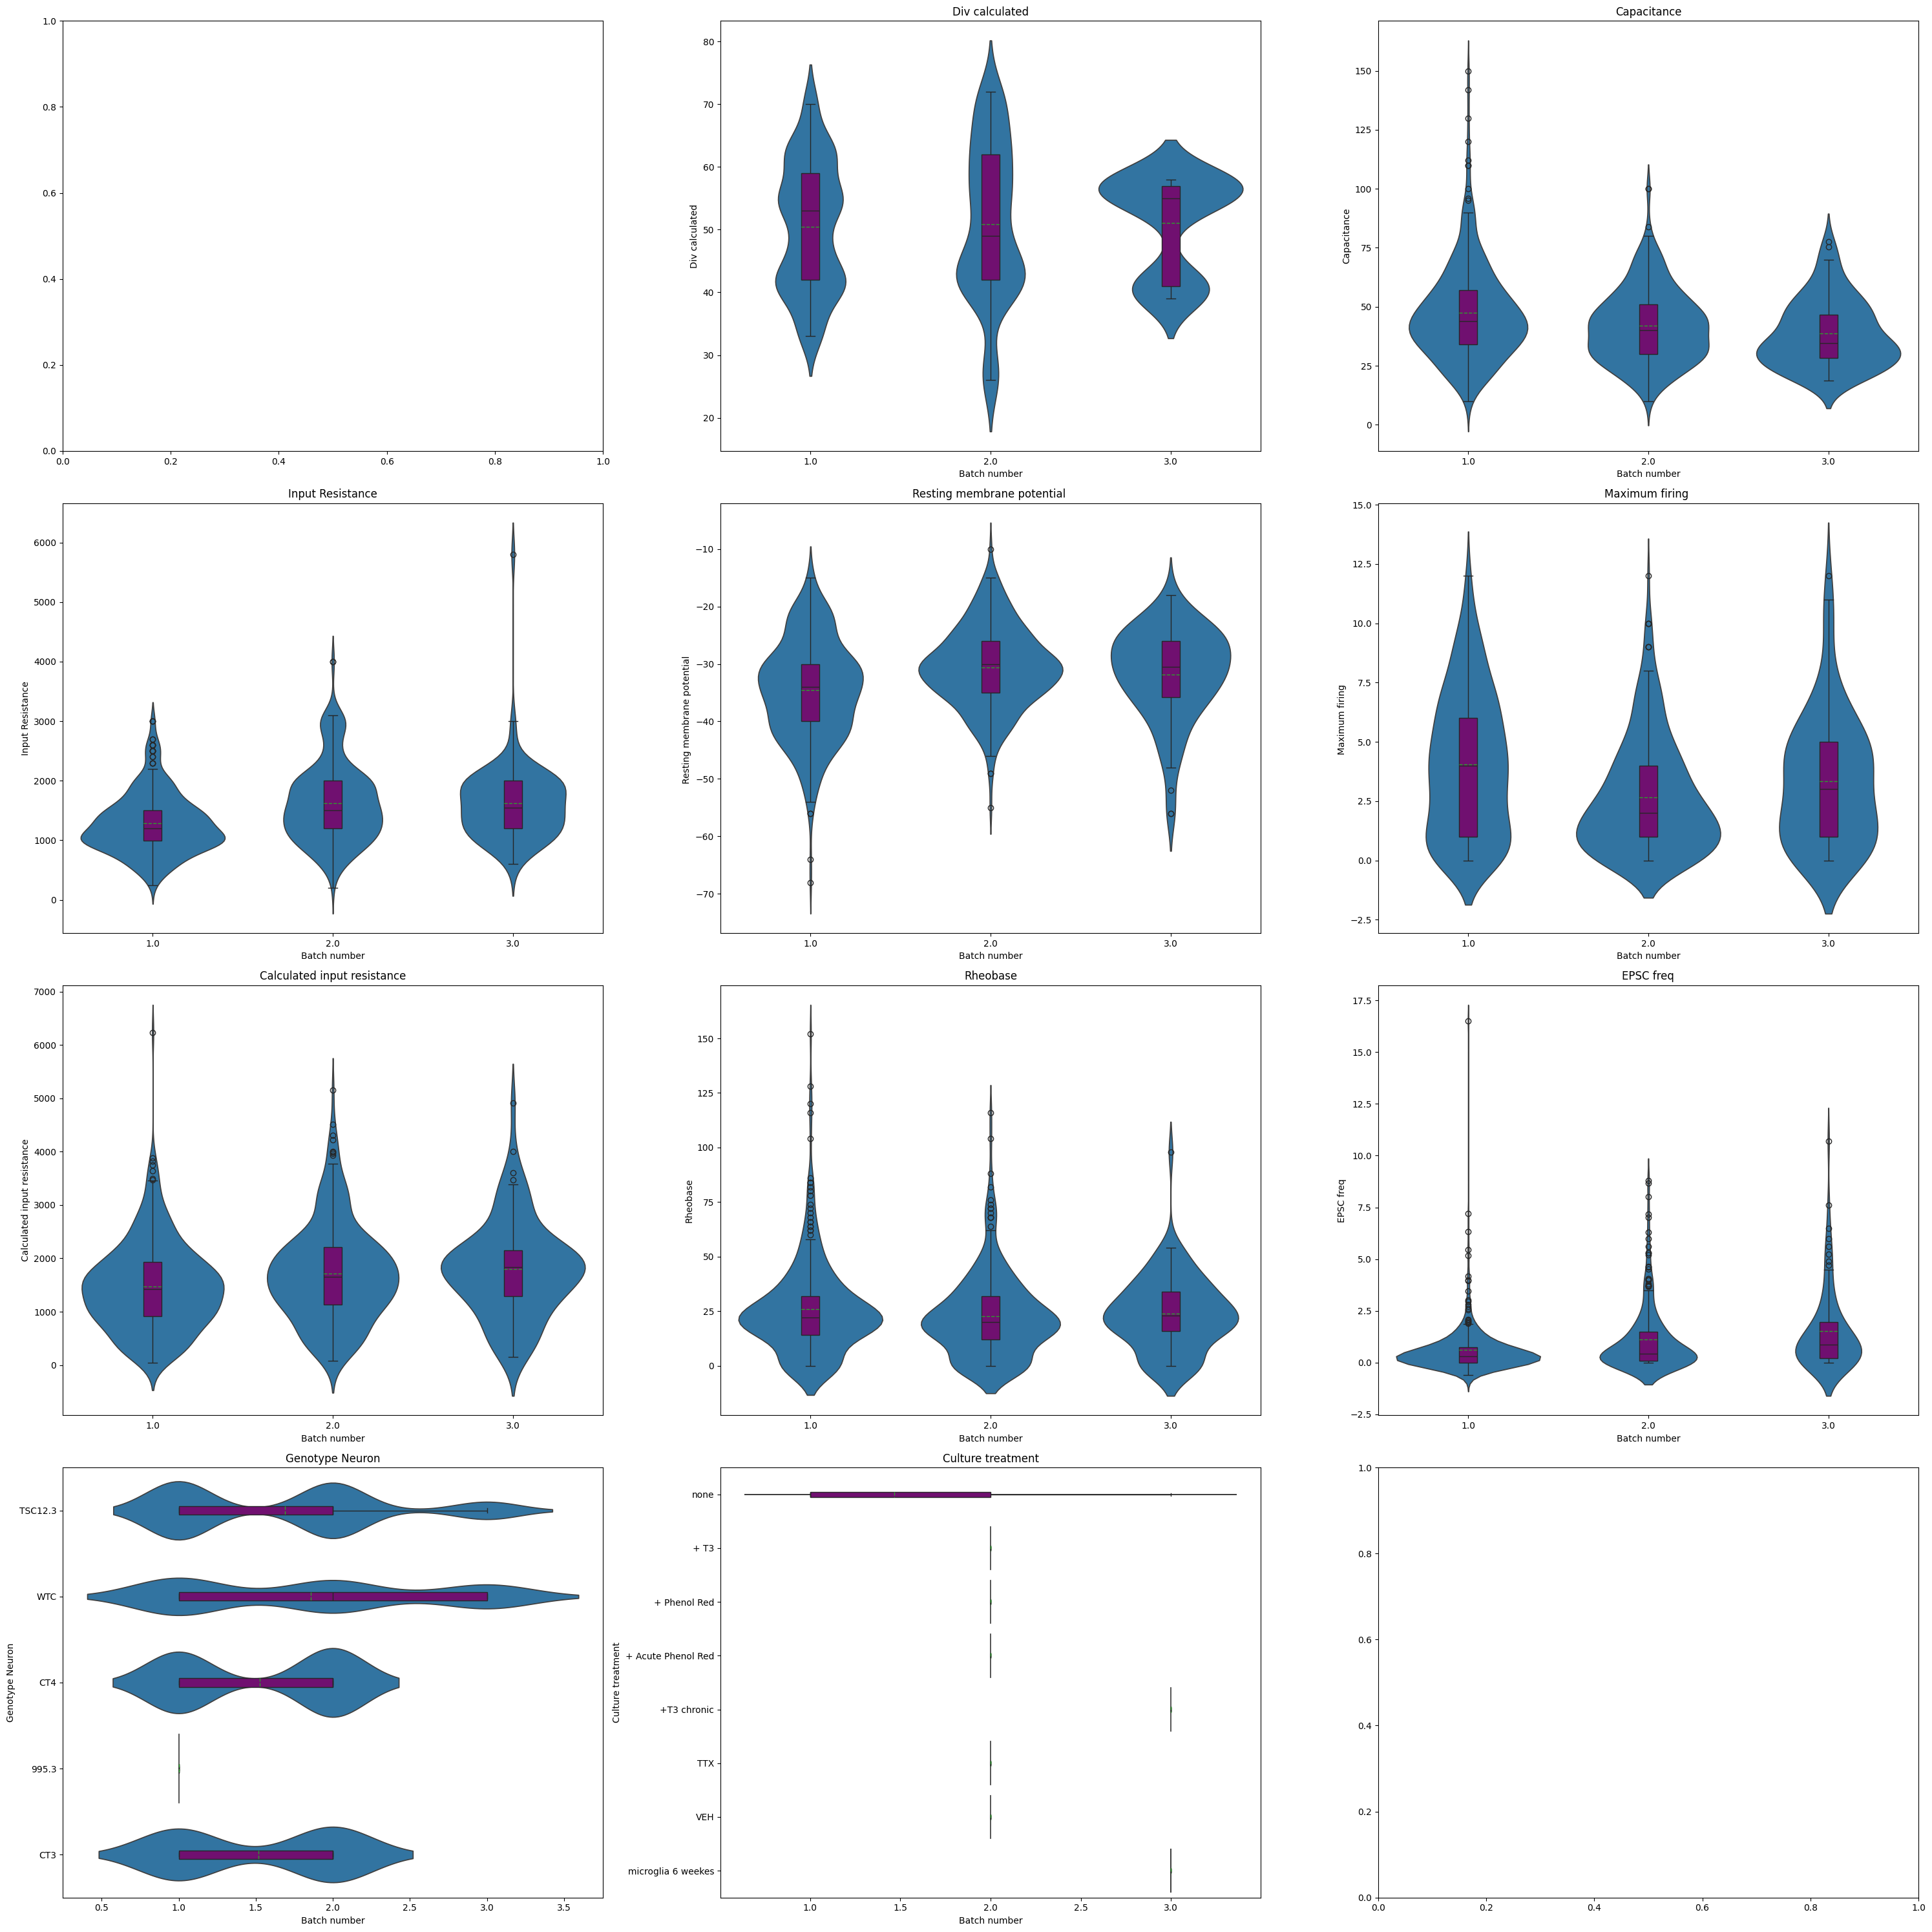

In [44]:
# sns.violinplot(x='Genotype Neuron', y='Capacitance', data=data_extracted_features_imputed, inner=None)
# sns.boxplot(x='Genotype Neuron', y='Capacitance', data=data_extracted_features_imputed, width=0.2, color="purple", showmeans=True, meanline=True)  
# plt.xlabel("Genotype Neuron")
# plt.ylabel("Capacitance")
# plt.title("Ephys violinplot")
# plt.show()

# g = sns.FacetGrid(data_extracted_features_imputed, col='Genotype Neuron', col_wrap=4, height=4, sharex=True)
# g.map(sns.violinplot, 'Batch number', 'Div calculated', inner=None)
# plt.tight_layout()
# plt.show

fig, axes = plt.subplots(4, 3, figsize=(30, 30))
axes = axes.flatten()
for i, feature in enumerate(data_extracted_features_imputed.columns):
    if feature == 'Batch number':
        continue
    sns.violinplot(x='Batch number', y=feature, data=data_extracted_features_imputed, ax=axes[i], inner=None)
    sns.boxplot(x='Batch number', y=feature, data=data_extracted_features_imputed, ax=axes[i], width=0.1, color="purple", showmeans=True, meanline=True)
    axes[i].set_title(feature)
plt.tight_layout()
plt.show()